In [14]:

import gc
import time
import sys
import re
import pickle

from IPython.core.debugger import set_trace
from IPython.display import Audio, display

import numpy as np
import pandas as pd

# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from contextlib import contextmanager

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, fbeta_score, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import xgboost
from xgboost.sklearn import XGBClassifier   
from catboost import CatBoostClassifier

import shap
import category_encoders as ce



In [15]:
### Helper functions (general)



print('\nLibraries version :\n')
print('Python     : ' + sys.version)
print('NumPy      : ' + np.__version__)
print('Pandas     : ' + pd.__version__)
# print('Matplotlib : ' + mpl.__version__)
print('Seaborn    : ' + sns.__version__)
# import sklearn
# print('SkLearn    : ' + sklearn.__version__)

"""
On Kaggle:
Libraries version :
Python     : 3.7.12 | packaged by conda-forge  
NumPy      : 1.19.5 now 1.21.5 (april'22)
Pandas     : 1.3.4 now 1.3.5
Matplotlib : 3.5.1
Seaborn    : 0.11.2
SKlearn    : 0.23.2  #1.02 since april'22

On Kaggle (with latest environment option):
Libraries version :
Python     : 3.7.12 | packaged by conda-forge  
NumPy      : 1.20.3
Pandas     : 1.3.5
Matplotlib : 3.5.1
Seaborn    : 0.11.2
SKlearn    : 1.0.1
"""

# ipympl have pb installation in kaggle
# %conda install ipympl  
# %matplotlib widget

# %matplotlib qt
# %matplotlib notebook 
# to get interactive plot (can zoom & horiz. scroll but change layout 
#   from inline)   # or %matplotlib qt ?
# usage error when comments after jupyter magic command!!
%matplotlib inline

#custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='paper')   #rc=custom_params
# context: "notebook"(default), “paper”, “talk”, and “poster”  
#   for scaling/sizes
# style: darkgrid(default), whitegrid, dark, white, ticks  #for general 
#   style of the plots
# palette: deep(default), muted, bright, pastel, dark, colorblind, ... 
#   paste1,..., set2, ..., 
#   ‘light:<color>’, ‘dark:<color>’, ‘blend:<color>,<color>   
#   https://seaborn.pydata.org/tutorial/color_palettes.html   



# pd.set_option('display.width', 120)
pd.set_option('display.max_columns', None)  # print all columns
# pd.set_option('display.show_dimensions', True)  # to always show the 
#   dimensions of the df when printed

# # np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
np.set_printoptions(edgeitems=5, linewidth=120,
                    formatter={'float': '{: 0.3f}'.format})


nl = "\n"

CEND    = '\33[0m'  ; CBOLD   = '\33[1m'  ; CITALIC = '\33[3m'   
CUDL    = '\33[4m'  ; CYELLOW = '\33[33m' ; CWHITE  = '\33[37m'
CBLACK  = '\33[30m' ; CRED    = '\33[31m' ; CGREEN  = '\33[32m' 
CBLUE   = '\33[34m' ; CVIOLET = '\33[35m' ; CBEIGE  = '\33[36m' 




def myprint(text, color, bold=False, udl=False, italic=False):  
    '''Print in color, bold, underlined or italic'''
    # [Or use html from ipython]
    
    s = ''
    if bold:   s += CBOLD
    if udl:    s += CUDL
    if italic: s += CITALIC
    s += color + text + CEND + '\n'
    print(s)


    
def explore(df, miss=True, valcount=True): 
    '''Basic exploration on a dataframe'''

    # pb when lists in the column and do df.count_values()
    #  the pb is the memory size, it works for 10k lines but not 100k
       
    myprint('\n----- FIRST LINES -----', CVIOLET, bold=True, udl=True, 
            italic=False)
    display(df.head(5))
    # print(df.shape, '\n') ; # print(df.dtypes, '\n')
    
    myprint('\n----- INFO -----', CVIOLET, bold=True, udl=True, 
            italic=False)
    display(pd.DataFrame(df.info(memory_usage='deep', verbose=True, 
                                 show_counts=True)))  
    
    myprint('\n----- DESCRIBE -----', CVIOLET, bold=True, udl=True, 
            italic=False)
    try: 
        display(pd.DataFrame(df.describe(include=['number'])))
        display(pd.DataFrame(df.describe(include=['object'])))
        #display(pd.DataFrame(df.describe(include=['category'])))
    except ValueError:  #if no number columns or no object columns
        pass
    
    # Unique and missing values per column
    if miss:
        uni_miss(df)
    
    # Value counts per column
    if valcount: 
        myvalcount(df, 10)
    
            

def uni_miss(df):
    '''For the chosen columns of a DF, gives the number/% of missing 
          values and the number of unique values
       Example: uni_miss(data0[['len code']])
    '''
    
    print('\n-----', namestr(df, globals()) )#[0])
    myprint('----- MISSING AND UNIQUE VALUES -----', CVIOLET, bold=True, 
            udl=True, italic=False)

    df1 = pd.Series(df.isna().mean())
    df2 = pd.Series(df.isna().sum())
    df3 = pd.concat([df1,df2], axis=1)
    df3.columns = ['%missing', '#missing']
    df3['#values'] = df.shape[0] - df3['#missing'] 
    if isinstance(df,pd.DataFrame):
        df3['#unique'] = [len(df[c].apply(lambda x: str(x)).unique()) 
                          for c in df.columns]  #includes NaN
        #tod: substract 1 when NaN in list to have count w/o NaN
        df3['type'] = [df[c].dtypes for c in df.columns] 
    else:   # if df is a Series or one column of a DataFrame
        df3['#unique'] = [len(df.apply(lambda x: str(x)).unique())]  #includes NaN
        df3['type'] = [df.dtypes]  

    # Use incremental number index to get number of indicators
    df3['column'] = df3.index
    df3.reset_index(drop=True, inplace=True)
    df3.sort_values('%missing', inplace=True)
    df3.index = np.arange(1, len(df3) + 1)
    # Arrange the order of the columns
    cols = list(df3.columns)
    cols = [cols[-1]] + cols[:-1]
    df3 = df3[cols]
    
    with pd.option_context('display.max_rows', None):
        display(df3.sort_values(by='%missing'))
    

     
def myvalcount(df, n_top=10):
    '''For each DF column, gives the list of the n_top most frequent 
          values and the number of occurences
       Example: myvalcount(data0[['len code']])
       Too slow (jam) if 100k lines of lists
    '''
    
    if isinstance(df,pd.DataFrame):
        cols = df.columns
    else:   # if df is a Series or one column of a DataFrame
        cols = df.name  
    myprint('\n----- VALUE COUNTS -----', CVIOLET, bold=True, udl=True, 
            italic=False)
    for col in cols:
        res = pd.DataFrame(df[col].value_counts(dropna=False)).head(n_top)
        myprint('\nTop ' + str(n_top) + ' value counts for ' + str(col) 
                + ' (' + str(len(res)) + ' mod.):', 
                CGREEN, bold=True, udl=True, italic=False)
        display(res)
    return res    


        
def visudf(df, text='', n=10):
    '''Display some infos on a dataframe/series'''
    
    #print('\nName:', namestr(df, locals())[0])
    print('\n', text, ':')
    print('Object:', type(df))
    print('Shape:', df.shape)
    print('Types:', df.dtypes)
    mydisplay(df.head(n))
    print('\n')
    
    
    
def mem_usage(pandas_obj, list_typ):
    '''Display the memory usage of a dataframe by type
       Example: mem_usage(data0, ['float','int','object'])  
    '''
    
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    print("\n{:03.2f} MB".format(usage_mb))  #same as sys.getsizeof
        # (data0)/1024**2

    for dtype in list_typ:
        selected_dtype = data0.select_dtypes(include=[dtype])
        sum_usage_b = selected_dtype.memory_usage(deep=True).sum()
        sum_usage_mb = sum_usage_b / 1024 ** 2
        print("Total memory usage for {} columns: {:03.2f} MB"
              .format(dtype,sum_usage_mb))
        

        
def mydisplay(df, gen_width=100, gens=None, dig=2, digs=None):
    '''Pretty display of a DataFrame
       gen_width is the width in pixels for all columns
       gens is a dictionary giving specified width for some columns 
          (ex: gens['colname']=60)
       dig is the number of digits after the dot for all numeric columns
       digs is a dictionary giving specified dig for some columns
    '''
    
    if isinstance(df, pd.Series):
        df = df.to_frame()
    dfs = (df.style
             .set_table_styles([dict(selector="table, th, td", 
                                     props=[('border', '1px solid indigo'),   
                                            # {N}px solid {color}  
                                            ('border-collapse', 'collapse'),  
                                            # or ('border-color', '#96D4D4')
                                            ])], overwrite=False)
#              # To change the background one row out of two 
#              .set_table_styles([dict(selector="tr:nth-child(even)", 
#                                      props=[('background-color', 
#                                                  '#0a3948'), #2E2E2E
#                                             ])], overwrite=False)
             # Header
             .set_table_styles([dict(selector="th", 
                                     props=[('text-align', 'center'),
                                            ('word-break', 'break-all'),
                                            ('min-width', str(gen_width) 
                                             + 'px'),   #'120px' or '30em'
                                            ('max-width', str(gen_width) 
                                             + 'px'),
                                            ('overflow', 'hidden'), 
                                            ('text-overflow', 'ellipsis'), 
                                            ('white-space', 'nowrap'),
                                            ])], overwrite=False)             
             # Data (cells)
             .set_table_styles([dict(selector="td", 
                                     props=[('text-align', 'center'),
                                            ('word-break', 'break-all'), 
                                              # ('word-wrap', 'break-word')
                                            ('min-width', str(gen_width) 
                                             + 'px'), 
                                            ('max-width', str(gen_width) 
                                             + 'px'),
                                            ('overflow', 'hidden'),      
                                              # necessary to cut text when 
                                              #   arrives at column width
                                            ('text-overflow', 'ellipsis'), 
                                            ('white-space', 'nowrap'),
                                            ])], overwrite=False)
#              #To change only selected columns (may need to do the 
#              #  same for th also)
#              if gens is not None:
#                    for col in gens.keys:
#                      .set_table_styles({col :[dict(selector='td', 
#                                              props=[('min-width', 
#                                              str(gens[col]) + 'px'),
#                                                     ('max-width', 
#                                                      str(gens[col]) 
#                                                          + 'px'),
#                                                   ])]}, overwrite=False) 
             # To show the full text when the mouse hover a cut text
             .set_table_styles([dict(selector="td:hover", 
                                     props=[('overflow', 'visible'),
                                            ('white-space', 'unset'),
                                           ])], overwrite=False) 
             .set_table_styles([dict(selector="th:hover",  
                                     props=[('overflow', 'visible'),
                                            ('white-space', 'unset'),
                                           ])], overwrite=False)
#              .set_properties(subset=df.columns[0:3].values, 
#                              **{'width': '10px'}, 
#                              **{'max-width': '10px'})
    # If not overwrite=False, the parameters set before are deleted
    # For color code like '#2E2E2E' : 
    #   https://htmlcolorcodes.com/fr/selecteur-de-couleur/
    # For color name like 'indigo':  
    #   https://www.computerhope.com/jargon/w/w3c-color-names.htm 

    # .set_properties(**{'white-space': 'wrap'}) 
    # .set_properties(subset=['url'], **{'width': '46px'})#, 
    #                 **{'max-width:'46px'})   # for only some columns
    # num_col_mask = df.dtypes.apply(lambda d: issubclass(np.dtype(d).type,
    #                       np.number)) / subset=df.columns[num_col_mask]    
    # #To change only selected columns (may need to do the same 
    # #  for th also)
    ) 
    
    if gens is not None:
        for col in gens.keys():
             dfs = dfs.set_table_styles({col :[dict(selector='td', 
                                     props=[('min-width', str(gens[col]) 
                                             + 'px'),
                                            ('max-width', str(gens[col]) 
                                             + 'px'),
                                           ])]}, overwrite=False)        
            
    dfs = dfs.format(precision=dig) 
#     df.style.format(precision=0, na_rep='MISSING', thousands=" ",
#                 formatter={('Decision Tree', 'Tumour'): "{:.2f}",
#                            ('Regression', 'Non-Tumour'): lambda x: 
#                                "$ {:,.1f}".format(x*-1e6)  })

    print(len(df), 'lines')
    display(dfs) 

    

    
def sep_func():
    '''Display a separator line & the function name at the start 
          of a function
    '''
    
    print(nl, 50*'-', sys._getframe().f_back.f_code.co_name, nl)
    #print(nl, 50*'-', sys._getframe().f_code.co_name, nl)
    a = 1
    


    
def ordered_boxplot(x, y, data):
    '''Draw a boxplot of data[x] by data[y] ordered according to the 
          mean value of the boxes
       x and y are column names from dataframe data
       The count of each modality is added to y tick labels, as well 
          as a marker for the mean of each box
    '''
    
    grouped = (data.loc[:,[x, y]]
                   .groupby(y)
                   .agg({x:['median', 'count']})
                   .sort_values(by=(x, 'median'), ascending=False)
              )
    fig, ax = plt.subplots(figsize=(15,11)) 
    g = sns.boxplot(x=x, y=y, data=data, ax=ax, order=grouped.index, 
                    showmeans=True,   #, showfliers=False, orient='h'
                    meanprops={"marker":"s","markerfacecolor":"white", 
                               "markeredgecolor":"blue", "markersize":"3"})  
    #g.set_xticklabels(g.get_xticklabels(), rotation=45, fontsize=10, 
    #  horizontalalignment='right')
    ax.set_yticklabels([ind + ' (' + str(grouped.loc[ind, (x, 'count')]) 
                        + ')' for ind in grouped.index])
                        #, fontdict={'fontsize': 7})
    plt.show()    
#     print([ind + ' (' + str(grouped.loc[ind, (x, 'count')]) + ')' 
#            for ind in grouped.index])




def mysound(): 
    '''Play a sound (when program finishes, when error, ...)'''
    
    play_time_seconds = 1  ;  framerate = 4410
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
    audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
    display(Audio(audio_data, rate=framerate, autoplay=True))
    
    
    
def custom_exc(shell, etype, evalue, tb, tb_offset=None):
    '''This function will be called on exceptions in any cell'''
    
    shell.showtraceback((etype, evalue, tb), tb_offset=tb_offset)
    mysound()    
    
# Play a sound when any error occurs    
get_ipython().set_custom_exc((Exception,), custom_exc)



    
def mygarbage():
    '''Manual garbage collection (but doesn't seem to be effective)'''
    
    print(nl*3, "Garbage Collection", nl, "threshold:", gc.get_threshold()) 
    # gc.set_threshold()  #to get/set the threshold of automatic 
    #                     #  garbage collection for the 3 generations
    print("len(get_objects):",len(gc.get_objects()))
    print("stats:",gc.get_stats())
    print("count:",gc.get_count())  #number of objects for each generation
    #gc.garbage
    print("nb of collected:", gc.collect(),'\n')  #manual garbage collection
    print("len(get_objects):",len(gc.get_objects()))
    print("stats:",gc.get_stats())
    print("count:",gc.get_count(), nl*3)  #number of objects for each gen.

mygarbage()
    
    
    
    
# Quick function to pretty print & format numbers in a list
f_pr0 = lambda list1: print(' - '.join('{:10,.0f}'.format(f)
                                       .replace(',', ' ') for f in list1))
f_pr3 = lambda list1: print(' - '.join('{:10,.3f}'.format(f)
                                       .replace(',', ' ') for f in list1))



# Get the name (as a string) of the variable
def namestr(obj, namespace):
    '''Get the name (as a string) of the variable
       Example: namestr(a, globals())[0]
    '''
    
    return [name for name in namespace if namespace[name] is obj]



# Plot all numerical and categorical variables in a df
def project_plot(data0, x_log0=True, y_log0=True):
    '''Plots to explore numerical and categoricaldata and look for outliers
       x_log & y_log to choose the scale of the plots on numeric 
          variables (easier to find outliers)
    '''
    
    data0 = data0.copy()
    max_mod = 30  # max number of modalities displayed per categorical var.
    
    # General data histograms
    data0.hist(figsize=(15,14), bins=30)
    plt.tight_layout()
    plt.show()
    
    
    # # Pairplot (takes several minutes)
    # sns.pairplot(data0, hue='BuildingType', corner=True)
    # plt.savefig('./pairplot5.png', dpi=400) 
#     lcol = list(data0.select_dtypes(include=[np.number]).columns)
#     sns.pairplot(data0, vars=lcol, kind='reg', diag_kind='kde', 
#                  plot_kws={'scatter_kws': {'alpha': 0.1}})
#     plt.show()
    
    
    
    # Plot numeric (and date) data to see if outliers (use log on x and y)
    num_cols = data0.select_dtypes(include=['number', 'datetime64[ns]']
                                  ).columns
    for c in num_cols:
        print(nl, c)
        x_log, y_log = x_log0, y_log0
        if data0[c].dtype == 'datetime64[ns]':
            x_log = False
            format1 ="%Y/%m/%d"
            data_date = pd.to_datetime(data0[c]).dt.date  # dtype=object 
                # if dt.date   or better use dt.floor('d') to keep type
            val1 = pd.to_datetime(np.unique(data_date
                                            .sort_values()
                                            .values)[:15])  
            val2 = pd.to_datetime(np.unique(data_date
                                            .sort_values()
                                            .values)[-15:][::-1])
            print(' unique min =', [x.strftime(format1) if x==x else 'NaN' 
                                                        for x in val1])
            print(' unique max =', [x.strftime(format1) if x==x else 'NaN' 
                                                        for x in val2])  
        else:
            print(' unique min =', [round(x, 1) if (abs(x)>=1) 
                                                else round(x, 3) 
                                    for x in np.unique(data0[c]
                                                       .sort_values()
                                                       .values)[:15]])
            print(' unique max =', [round(x, 1) if (abs(x)>=1) 
                                                else round(x, 3) 
                                    for x in np.unique(data0[c]
                                                       .sort_values()
                                                       .values)[-15:][::-1]])
        #data0b = data0.loc[data0[c]>0, c]  #remove value 0 just for 
        ##    plotting (for a better zoom)   
        ##    to update if values negative possible
        data0b = data0[c]
        fig, ax = plt.subplots(figsize=(15,7))
        x_min, x_max = data0b.min(), data0b.max() 
#         if data0b.dtype != 'datetime64[ns]':
#             print('***', x_log, ((x_max-x_min)>1000))
        if x_min == 0:
            x_min=1e-5
        if x_log and ((x_max-x_min)>100):
            bins = np.geomspace(x_min, x_max, 250) #error if 0 in geomspace
            ax.set_xscale('log')
        else:
            bins = 250
            
        data0b.hist(bins=bins, log=y_log)  
        
        ax.tick_params(axis='both', which='minor', bottom=True, left=True)
        ax.tick_params(axis='both', which='major', bottom=True, left=True)

        myxticks = [x for x in ax.get_xticks(minor=True) 
                    if (x>=x_min)*(x<=x_max)]
        myxlabels = [str(x) for x in myxticks]
        ax.set_xticks(myxticks, minor=True) #to avoid warning (xticks are 
            #the location and xticklabels their labels)
        ax.set_xticklabels(myxlabels, rotation=30, fontsize=8, minor=True, 
                           horizontalalignment='right')

        ax.set_xticks(ax.get_xticks()) #to avoid warning
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=8, 
                           horizontalalignment='right')
        
        if data0[c].dtype != 'datetime64[ns]':
            print(data0[c].dtype)
#             format1 = format(x)
#         elif x_max >= 100:
#             format1 = format(round(x, 1), ',')
#         else:
#             format1 = format(round(x, 2), ',')
            nb = 1 if x_max >= 100 else 2
            ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(
                lambda x, p: format(round(x, nb), ','))) #int(x)
            ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(
                lambda x, p: format(round(x, nb), ',')))
            ax.get_yaxis().set_minor_formatter(mpl.ticker.FuncFormatter(
                lambda x, p: format(round(x, nb), ',')))
            ax.get_xaxis().set_minor_formatter(mpl.ticker.FuncFormatter(
                lambda x, p: format(round(x, nb), ',')))
            ax.set_xlim(x_min, x_max) #must be at the end to get only 
                #plot for [x_min, x_max]
        plt.show()

        

    # Plot categorical data (count plot)
    for c in data0.select_dtypes(include=['object']).columns:
        # trick because miss the case where we have like [1] which 
        #  is not considered as a list in pyhton
        if 1:#(str(data0.iloc[1].loc[c])[0] != '[') and 
            #(sum(data0[c].isna())==0): 
            print(nl, c)
            # if it contains a list, simply take the 1st element 
            #   (often there is only one element in the list)
            data0[c] = data0[c].map(lambda x: x[0] if isinstance(x, list) 
                                              else x)
            col_order = data0[c].value_counts().index
            col_order = col_order[0:min(max_mod, len(col_order))]
            mydisplay(data0[c].head())
            print(type(col_order), col_order[:10])
            fig, ax = plt.subplots(figsize=(15, 0.35*len(col_order)))
            sns.countplot(y=c, order=col_order, data=data0)

            # Print the value next to each bar
            xmin, xmax = plt.xlim()
            for p in ax.patches:
                width = p.get_width()  # get bar length
                ax.text(width + np.sqrt(xmax - 3)/10,  
                        # set the text just after the bar
                p.get_y() + p.get_height() / 2,  
                        # get Y coordinate + X coordinate / 2
                '{:1.0f}'.format(width), ha = 'left', va = 'center')  
                        # vertical alignment
            plt.show()
        
#         # Display the counts for each modality 
#         with pd.option_context('display.max_rows', None):
#             mydisplay(data0[c].value_counts().sort_index()
#                               .reset_index().head(100))



def mytimer(message):   
    ''' Multi-Chronometer
        Use first start_time = time.time()
    '''
    
    print(f"\n**** {time.time() - start_time:.2f} seconds --- {message}\n")

In [16]:
# GLOBAL CONSTANTS

PATH_DATA = '../input/home-credit-default-risk/'
# https://www.kaggle.com/c/home-credit-default-risk/data

SEED = 0


# TRAIN_SIZE, TRAIN_SIZE = 1, 1   # to use if real run & not 'debug' mode
# For debug (quick run/test):
TRAIN_SIZE = 30000
TEST_SIZE = 1 + 0*int(TRAIN_SIZE / 307.5 * 48.7)


THRESHOLD1 = 0.5   # for ROC, ...


P_NAN = 0.30   # max. % of NaN per variable (1.00 to take all variables)
# Look at the top 36 variables importance by taking all variables (whatever NaN count)
# not in top100: 
NAN_KEEP1 =['EXT_SOURCE_1', 'REFUSED_DAYS_DECISION_MAX', 'INSTAL_AMT_PAYMENT_MIN', 
            'POS_COUNT', 'CLOSED_AMT_CREDIT_SUM_DEBT_SUM', 'APPROVED_CNT_PAYMENT_MEAN', 
            'PREV_CNT_PAYMENT_MEAN', 'AMT_CREDIT'
    ]
# not in top 50 but top 50-60: 
NAN_KEEP2 = ['APPROVED_APP_CREDIT_PERC_MEAN', 'CLOSED_AMT_CREDIT_SUM_MEAN', 
#              'CLOSED_AMT_CREDIT_SUM_MEAN', 'AMT_REQ_CREDIT_BUREAU_QRT', 
#              'INSTAL_PAYMENT_DIFF_MAX'
    ]
NAN_KEEP = NAN_KEEP1 + NAN_KEEP2


CAT_VAR = []
CAT_VAR0 = [   # list of categorical variables
        'NAME_CONTRACT_TYPE',
        'CODE_GENDER',
        'FLAG_OWN_CAR',
        'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE',
        'NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE',
        'FLAG_MOBIL',
        'FLAG_EMP_PHONE',
        'FLAG_WORK_PHONE',
        'FLAG_CONT_MOBILE',
        'FLAG_PHONE',
        'FLAG_EMAIL',
        'OCCUPATION_TYPE',
        'WEEKDAY_APPR_PROCESS_START',
        'HOUR_APPR_PROCESS_START',
        'REG_REGION_NOT_LIVE_REGION',
        'REG_REGION_NOT_WORK_REGION',
        'LIVE_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_LIVE_CITY',
        'REG_CITY_NOT_WORK_CITY',
        'LIVE_CITY_NOT_WORK_CITY',
        'ORGANIZATION_TYPE',
        'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE',
        'WALLSMATERIAL_MODE',
        'EMERGENCYSTATE_MODE',
        'FLAG_DOCUMENT_2',
        'FLAG_DOCUMENT_3',
        'FLAG_DOCUMENT_4',
        'FLAG_DOCUMENT_5',
        'FLAG_DOCUMENT_6',
        'FLAG_DOCUMENT_7',
        'FLAG_DOCUMENT_8',
        'FLAG_DOCUMENT_9',
        'FLAG_DOCUMENT_10',
        'FLAG_DOCUMENT_11',
        'FLAG_DOCUMENT_12',
        'FLAG_DOCUMENT_13',
        'FLAG_DOCUMENT_14',
        'FLAG_DOCUMENT_15',
        'FLAG_DOCUMENT_16',
        'FLAG_DOCUMENT_17',
        'FLAG_DOCUMENT_18',
        'FLAG_DOCUMENT_19',
        'FLAG_DOCUMENT_20',
        'FLAG_DOCUMENT_21',
        'CREDIT_ACTIVE',
        'CREDIT_CURRENCY',
        'CREDIT_TYPE',
        'STATUS',
        'NAME_CONTRACT_STATUS',
        'NAME_CONTRACT_STATUS',
        'NAME_CONTRACT_TYPE',
        'WEEKDAY_APPR_PROCESS_START',
        'HOUR_APPR_PROCESS_START',
        'FLAG_LAST_APPL_PER_CONTRACT',
        'NFLAG_LAST_APPL_IN_DAY',
        'NFLAG_MICRO_CASH',
        'NAME_CASH_LOAN_PURPOSE',
        'NAME_CONTRACT_STATUS',
        'NAME_PAYMENT_TYPE',
        'CODE_REJECT_REASON',
        'NAME_TYPE_SUITE',
        'NAME_CLIENT_TYPE',
        'NAME_GOODS_CATEGORY',
        'NAME_PORTFOLIO',
        'NAME_PRODUCT_TYPE',
        'CHANNEL_TYPE',
        'NAME_SELLER_INDUSTRY',
        'NAME_YIELD_GROUP',
        'PRODUCT_COMBINATION',
        'NFLAG_INSURED_ON_APPROVAL',
    ]

# top50 tree > top50 permut > top100 permut > top75 permut > top all

# Top variables from Permutation Importance  

#---old------------------------------
# TOP50_VAR =  [
#         'EXT_SOURCE_3', 'EXT_SOURCE_2', 'CODE_GENDER', 'DAYS_BIRTH',
#         'PAYMENT_RATE', 'PREV_APP_CREDIT_PERC_MAX', 'NAME_EDUCATION_TYPE',
#         'ANNUITY_INCOME_PERC', 'INSTAL_PAYMENT_DIFF_MEAN', 'DAYS_EMPLOYED',
#         'PREV_AMT_ANNUITY_MIN', 'BURO_DAYS_CREDIT_MIN',
#         'PREV_APP_CREDIT_PERC_MEAN', 'AMT_ANNUITY', 'DAYS_EMPLOYED_PERC',
#         'INSTAL_DPD_MEAN', 'PREV_APP_CREDIT_PERC_MIN', 'DAYS_LAST_PHONE_CHANGE',
#         'APPROVED_AMT_CREDIT_MIN', 'PREV_CNT_PAYMENT_MEAN', 'DAYS_ID_PUBLISH',
#         'INCOME_CREDIT_PERC', 'PREV_DAYS_DECISION_MEAN',
#         'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'FLAG_DOCUMENT_3', 'INSTAL_DBD_SUM',
#         'PREV_NAME_CONTRACT_STATUS_MODE2', 'APPROVED_AMT_APPLICATION_MIN',
#         'INSTAL_AMT_INSTALMENT_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
#         'INSTAL_PAYMENT_PERC_SUM', 'BURO_AMT_CREDIT_SUM_MAX',
#         'ACTIVE_DAYS_CREDIT_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
#         'APPROVED_AMT_GOODS_PRICE_MIN', 'REGION_RATING_CLIENT',
#         'CLOSED_DAYS_CREDIT_MAX', 'INSTAL_DPD_MAX',
#         'APPROVED_HOUR_APPR_PROCESS_START_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
#         'BURO_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_MAX',
#         'AMT_REQ_CREDIT_BUREAU_YEAR', 'INSTAL_DBD_MEAN', 'PREV_AMT_CREDIT_MEAN',
#         'APPROVED_DAYS_DECISION_MAX', 'INSTAL_PAYMENT_PERC_MEAN',
#         'PREV_AMT_CREDIT_MAX', 'CLOSED_AMT_CREDIT_SUM_MEAN', 'AMT_CREDIT'
#     ]

TOP50_VAR =  [
       'EXT_SOURCE_3', 'EXT_SOURCE_2', 'CODE_GENDER', 'DAYS_BIRTH',
       'PAYMENT_RATE', 'PREV_APP_CREDIT_PERC_MAX', 'NAME_EDUCATION_TYPE',
       'ANNUITY_INCOME_PERC', 'DAYS_EMPLOYED', 'INSTAL_PAYMENT_DIFF_MEAN',
       'PREV_AMT_ANNUITY_MIN', 'BURO_DAYS_CREDIT_MIN', 'DAYS_EMPLOYED_PERC',
       'PREV_APP_CREDIT_PERC_MEAN', 'AMT_ANNUITY', 'INSTAL_DPD_MEAN',
       'DAYS_LAST_PHONE_CHANGE', 'PREV_APP_CREDIT_PERC_MIN',
       'PREV_CNT_PAYMENT_MEAN', 'APPROVED_AMT_CREDIT_MIN', 'DAYS_ID_PUBLISH',
       'INCOME_CREDIT_PERC', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
       'PREV_DAYS_DECISION_MEAN', 'INSTAL_DBD_SUM',
       'APPROVED_AMT_APPLICATION_MIN', 'FLAG_DOCUMENT_3',
       'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'PREV_NAME_CONTRACT_STATUS_MODE2',
       'INSTAL_AMT_INSTALMENT_MAX', 'INSTAL_PAYMENT_PERC_SUM',
       'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'APPROVED_AMT_GOODS_PRICE_MIN',
       'BURO_AMT_CREDIT_SUM_SUM', 'REGION_RATING_CLIENT',
       'BURO_DAYS_CREDIT_MEAN', 'INSTAL_DBD_MEAN',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'CLOSED_DAYS_CREDIT_MAX',
       'ACTIVE_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_MAX', 'INSTAL_DPD_MAX',
       'BURO_AMT_CREDIT_SUM_MAX', 'APPROVED_DAYS_DECISION_MAX',
       'PREV_AMT_CREDIT_MAX', 'PREV_AMT_CREDIT_MEAN',
       'APPROVED_HOUR_APPR_PROCESS_START_MEAN', 'AMT_CREDIT',
       'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_AMT_PAYMENT_MAX',  # last=50th
#        'AMT_REQ_CREDIT_BUREAU_QRT', 'CLOSED_AMT_CREDIT_SUM_MEAN',
#        'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM', 'APPROVED_APP_CREDIT_PERC_MEAN',
#        'INSTAL_AMT_PAYMENT_SUM', 'APPROVED_AMT_ANNUITY_MIN',
#        'INSTAL_PAYMENT_PERC_VAR', 'INCOME_PER_PERSON',
#        'BURO_DAYS_CREDIT_UPDATE_MEAN', 'BURO_DAYS_CREDIT_ENDDATE_MAX',
#        'PREV_AMT_GOODS_PRICE_MEAN', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
#        'INSTAL_PAYMENT_DIFF_MAX', 'PREV_DAYS_DECISION_MIN',
#        'HOUR_APPR_PROCESS_START', 'INSTAL_DPD_SUM',
#        'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'PREV_APP_CREDIT_PERC_VAR',
#        'ACTIVE_AMT_CREDIT_SUM_MAX', 'POS_MONTHS_BALANCE_SIZE',
#        'POS_MONTHS_BALANCE_MAX', 'AMT_GOODS_PRICE',
#        'APPROVED_AMT_ANNUITY_MEAN', 'INSTAL_DBD_MAX',
#        'REGION_RATING_CLIENT_W_CITY', 'POS_SK_DPD_DEF_MEAN',  # last=76th
#        'NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE',
#        'PREV_NAME_PRODUCT_TYPE_MODE2', 'AMT_REQ_CREDIT_BUREAU_MON',
#        'BURO_MONTHS_BALANCE_SIZE_SUM', 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
#        'ACTIVE_AMT_CREDIT_SUM_MEAN', 'REGION_POPULATION_RELATIVE',
#        'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'PREV_AMT_GOODS_PRICE_MIN',
#        'CLOSED_AMT_CREDIT_SUM_MAX', 'PREV_AMT_ANNUITY_MEAN',
#        'INSTAL_AMT_INSTALMENT_SUM', 'PREV_NAME_GOODS_CATEGORY_MODE2',
#        'CNT_CHILDREN', 'POS_MONTHS_BALANCE_MEAN', 'AMT_INCOME_TOTAL',
#        'DAYS_REGISTRATION', 'WEEKDAY_APPR_PROCESS_START',
#        'APPROVED_DAYS_DECISION_MEAN', 'CLOSED_DAYS_CREDIT_MEAN',
#        'CLOSED_DAYS_CREDIT_MIN', 'ACTIVE_AMT_CREDIT_SUM_SUM',
#        'CLOSED_DAYS_CREDIT_ENDDATE_MAX'
    ]
TOP50_VAR =  TOP50_VAR + ['TARGET']


# # Top variables from Tree-based Importance
# TOP50_VAR = [
#         'EXT_SOURCE_3', 'EXT_SOURCE_2', 'PAYMENT_RATE', 'DAYS_EMPLOYED',
#        'DAYS_BIRTH', 'INSTAL_DPD_MEAN', 'PREV_APP_CREDIT_PERC_MEAN',
#        'PREV_APP_CREDIT_PERC_MAX', 'CODE_GENDER', 'ANNUITY_INCOME_PERC',
#        'AMT_ANNUITY', 'DAYS_EMPLOYED_PERC', 'PREV_AMT_ANNUITY_MIN',
#        'APPROVED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN',
#        'INSTAL_PAYMENT_DIFF_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'DAYS_ID_PUBLISH',
#        'NAME_EDUCATION_TYPE', 'BURO_AMT_CREDIT_SUM_SUM',
#        'PREV_APP_CREDIT_PERC_MIN', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
#        'APPROVED_HOUR_APPR_PROCESS_START_MEAN', 'DAYS_LAST_PHONE_CHANGE',
#        'INSTAL_AMT_PAYMENT_MIN', 'DAYS_REGISTRATION', 'PREV_DAYS_DECISION_MIN',
#        'INSTAL_AMT_PAYMENT_MAX', 'BURO_DAYS_CREDIT_MIN', 'INCOME_CREDIT_PERC',
#        'BURO_AMT_CREDIT_SUM_MAX', 'BURO_DAYS_CREDIT_MEAN',
#        'PREV_NAME_CONTRACT_STATUS_MODE2', 'FLAG_DOCUMENT_3',
#        'INSTAL_AMT_INSTALMENT_MAX', 'INSTAL_PAYMENT_PERC_SUM',
#        'INSTAL_DBD_SUM', 'BURO_DAYS_CREDIT_MAX',
#        'BURO_DAYS_CREDIT_UPDATE_MEAN', 'APPROVED_AMT_APPLICATION_MIN',
#        'POS_MONTHS_BALANCE_SIZE', 'PREV_DAYS_DECISION_MEAN',
#        'APPROVED_DAYS_DECISION_MIN', 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN',
#        'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'PREV_APP_CREDIT_PERC_VAR',
#        'APPROVED_AMT_CREDIT_MIN', 'PREV_NAME_GOODS_CATEGORY_MODE2',
#        'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN'
#     ]
# TOP50_VAR =  TOP50_VAR + ['TARGET']


# Columns with a correlation > 0.85 with another column
DROP_CORREL = [
        'DAYS_EMPLOYED_PERC', 'APPROVED_AMT_CREDIT_MIN', 'APPROVED_AMT_GOODS_PRICE_MIN'
        'BURO_AMT_CREDIT_SUM_SUM', 'PREV_APP_CREDIT_PERC_MEAN', 'PREV_AMT_ANNUITY_MIN'
        'INSTAL_AMT_PAYMENT_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'INSTAL_PAYMENT_PERC_VAR'
        'PREV_AMT_GOODS_PRICE_MEAN', 'BURO_AMT_CREDIT_SUM_MAX', 'AMT_GOODS_PRICE'
        'REGION_RATING_CLIENT_W_CITY'
    ]

In [17]:
###
# Select only the columns which have less than 30% of missing values
list_files = ['application_train.csv', 'bureau.csv',
              'bureau_balance.csv', 'previous_application.csv', 
              'POS_CASH_balance.csv', 'installments_payments.csv',
              'credit_card_balance.csv']
COL_SEL = []
for f in list_files:
    df_f = pd.read_csv(PATH_DATA + f)
    print('----', f)
    mydisplay(df_f.head(5))
    ser = df_f.isna().mean().sort_values(ascending=False)
    # Remove variables with too many NaN (also done at the end of Main)
    #mydisplay(ser[ser<0.30], gen_width=300)
    COL_SEL.extend(ser[ser<P_NAN].index)
NAN_KEEP = [col for col in NAN_KEEP if col not in COL_SEL]
COL_SEL.extend(NAN_KEEP)
    
print(len(COL_SEL))
print(len(set(COL_SEL)))
print(list(COL_SEL))

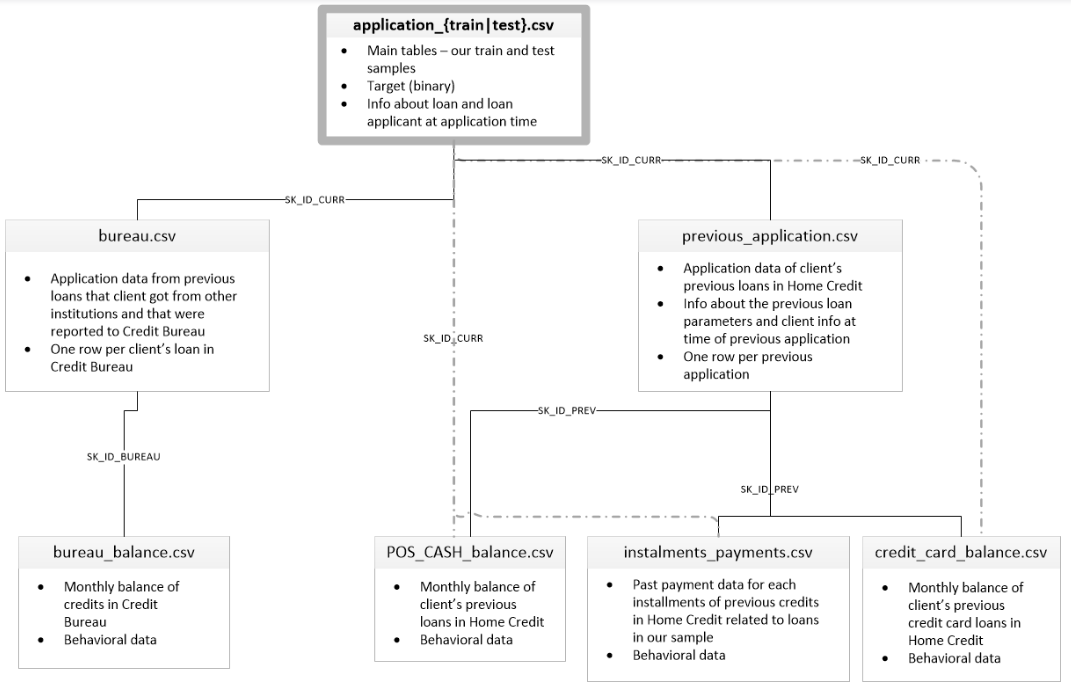

In [18]:
# # main_df has still 187 col sur 671 avec >30% de NaN
# ser = main_df.isna().mean().sort_values(ascending=False)
# mydisplay(ser[ser>0.30], gen_width=300)

# uni_miss(main_df)

# """
# 1	index	0.000000	0	30001	30001	int64
# 96	AMT_INCOME_TOTAL	0.000000	0	30001	556	float64
# 97	AMT_CREDIT	0.000000	0	30001	2828	float64
# 98	LIVE_CITY_NOT_WORK_CITY	0.000000	0	30001	2	int64
# 99	FLAG_DOCUMENT_9	0.000000	0	30001	2	int64
# 100	REG_CITY_NOT_WORK_CITY	0.000000	0	30001	2	int64
# """
# print(set(main_df['LIVE_CITY_NOT_WORK_CITY']))


In [19]:
"""

---Home Credit
Home Credit strives to broaden financial inclusion for the unbanked population 
by providing a positive and safe borrowing experience. In order to make sure this 
underserved population has a positive loan experience, Home Credit makes use of 
a variety of alternative data--including telco and transactional information--
to predict their clients' repayment abilities.

We primarily offer convenient and affordable point-of-sales (“POS”) loan, cash 
loan, and revolving loan products to underserved borrowers in nine countries 
(China, Kazakhstan, India, Indonesia, Vietnam, the Philippines, the Czech 
Republic and Slovakia)
Over our successful 22-year track record, we have accumulated a wealth of 
experience expanding our operations and navigating through credit cycles, while 
accumulating a large volume of borrower behaviour data which we use to refine 
risks and cross-selling.

---Credit Bureau
A credit bureau is a data collection agency that gathers account information 
from various creditors and provides that information to a consumer reporting 
agency in the United States.

A credit bureau, also known in the U.S. as a credit reporting agency, is an 
organization that collects and researches individual credit information and 
sells it to creditors for a fee, so they can make decisions about extending 
credit or granting loans.
The top three credit bureaus in the U.S. are Experian, Equifax, and TransUnion, 
although there are several others as well. Credit bureaus assign credit scores 
to individuals based on the credit history that they assemble.
Credit scores are important predictors of whether or not you will qualify for 
credit and on what terms. Credit bureaus do not decide whether or not you will 
get credit—they merely collect and synthesize information regarding your credit 
risk and give it to lending institutions.

"""


"""
Data Description

--- application_{train|test}.csv
This is the main table, broken into two files for Train (with TARGET) and 
Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

--- bureau.csv
All client's previous credits provided by other financial institutions that were 
reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the 
client had in Credit Bureau before the application date.

--- bureau_balance.csv
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported
to Credit Bureau – i.e the table has (#loans in sample * # of relative previous 
credits * # of months where we have some history observable for the previous 
credits) rows.

--- POS_CASH_balance.csv
Monthly balance snapshots of previous POS (point of sales) and cash loans that the 
applicant had with Home Credit. This table has one row for each month of history of 
every previous credit in Home Credit (consumer credit and cash loans) related to 
loans in our sample – i.e. the table has (#loans in sample * # of relative previous 
credits * # of months in which we have some history observable for the previous 
credits) rows.

--- credit_card_balance.csv
Monthly balance snapshots of previous credit cards that the applicant has with Home 
Credit. This table has one row for each month of history of every previous credit 
in Home Credit (consumer credit and cash loans) related to loans in our sample – 
i.e. the table has (#loans in sample * # of relative previous credit cards * # of 
months where we have some history observable for the previous credit card) rows.

--- previous_application.csv
All previous applications for Home Credit loans of clients who have loans in our 
sample. There is one row for each previous application related to loans in our data 
sample.

--- installments_payments.csv
Repayment history for the previously disbursed credits in Home Credit related to 
the loans in our sample. There is a) one row for every payment that was made plus b) 
one row each for missed payment. One row is equivalent to one payment of one 
installment OR one installment corresponding to one payment of one previous Home 
Credit credit related to loans in our sample.

--- HomeCredit_columns_description.csv
This file contains descriptions for the columns in the various data files.


-----------------------------
Target variable (1 - client with payment difficulties: he/she had late payment more 
than X days on at least one of the first Y installments of the loan in our sample, 
0 - all other cases)

""";

In [20]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.




@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

    
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True, categorical_columns=[]):
    """
    #     encoder = ce.TargetEncoder(cols=cat_var, smoothing=1.75)  #0.857 . doesn't do CV to avoid target leakage
    #     encoder = ce.LeaveOneOutEncoder(cols=cat_var, sigma=0.5)  # sigma=0.05 to 0.6  (gives around 0.75 instead of 0.85!)
    #     encoder = ce.CountEncoder(cols=cat_var)  # 0.835
    encoder = ce.OneHotEncoder(cols=cat_var, use_cat_names=True, handle_unknown='indicator')  #0.853  and sure no data-leaking so use it 
    # handle_unknown: ‘value’ will encode a new value as 0 in every dummy column. ‘indicator’ will add an additional dummy 
    #   column (in both training and test data).

    
    #if TE sees NaN it returns the target mean 
    X_train2 = encoder.fit_transform(X_train)#, y_train)  #author advises using fit_transform instead of fit then transform
    X_test2 = encoder.transform(X_test)
    print(nl, 'Encoding done on train and test sets', nl)
    #     X_train.drop(['LargestPropertyUseType_1', 'SecondLargestPropertyUseType_1'], axis=1, inplace=True)
    #     X_test.drop(['LargestPropertyUseType_1', 'SecondLargestPropertyUseType_1'], axis=1, inplace=True)
    #print(X_train.columns)
    # encoder.inverse_transform exists only for ordinal and one-hot

    """
    
#     original_columns = list(df.columns)
#     categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
#     categorical_columns = cat
    print('categ:', categorical_columns)
    print(df.columns)
#     categorical_columns = [col for col in ]
    
    if len(categorical_columns)>0: 
        mydisplay(df[categorical_columns].head(10))
    
    encoder = ce.CountEncoder(cols=categorical_columns, handle_missing='return_nan')
    df = encoder.fit_transform(df)#, y_train)  #author advises using fit_transform instead of fit then transform
# #     X_test2 = encoder.transform(X_test)      ## todo
    
#     df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    
#     new_columns = [c for c in df.columns if c not in original_columns]
    
    return df #, new_columns



# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    
    global CAT_VAR
    sep_func()
    # Read data and merge
    df = pd.read_csv(PATH_DATA + 'application_train.csv', nrows= num_rows) 
    df = df[[col for col in df.columns if col in COL_SEL]]
    #mydisplay(main_df.isna().mean().sort_values(ascending=False), gen_width=300)
    df, _ = train_test_split(df, train_size=TRAIN_SIZE, random_state=SEED, 
                             stratify=df['TARGET'])
    
    test_df = pd.read_csv(PATH_DATA + 'application_test.csv', nrows= num_rows)
    test_df = test_df[[col for col in test_df.columns if col in COL_SEL]]
    test_df, _ = train_test_split(test_df, train_size=TEST_SIZE, random_state=SEED)
    
    visudf(df) #; uni_miss(df)
    visudf(test_df) #; uni_miss(test_df)
    #     test_df = test_df.loc[df.index]
    #     ../input/home-credit-default-risk/application_train.csv
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)), nl)
    
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    # df = df[df['CODE_GENDER'] != 'XNA']
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
#     # Categorical features with Binary encode (0 or 1; two categories)
#     for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
#         df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df_cat = [col for col in df.columns if col in CAT_VAR0]
    df = one_hot_encoder(df, nan_as_category, df_cat)   ########  pass cat_coms to function
        # in theory should encode test on the basis of train encoding
    
#     CAT_VAR.extend(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'])
#     CAT_VAR.extend(cat_cols)
    
    del test_df
    gc.collect()
    
    return df 



# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True, idx = None):
    
    global CAT_VAR
    sep_func()
    bureau = pd.read_csv(PATH_DATA + 'bureau.csv', nrows = num_rows) 
    print('***', bureau.shape)
    bureau = bureau[bureau['SK_ID_CURR'].isin(idx)]   
    bureau = bureau[[col for col in bureau.columns if col in COL_SEL]]
    visudf(bureau) #; uni_miss(bureau)
    print('***', bureau.shape)
    
    bb = pd.read_csv(PATH_DATA + 'bureau_balance.csv', nrows = num_rows) 
    print('***', bb.shape)
    bb = bb[bb['SK_ID_BUREAU'].isin(bureau['SK_ID_BUREAU'])]
    bb= bb[[col for col in bb.columns if col in COL_SEL]]
    visudf(bb) #; uni_miss(bb)
    print('***', bureau.shape)
    print(idx[0:20])
    
#     bureau_cat = [col for col in bureau.columns if bureau[col].dtype == 'object']
#     bb_cat = [col for col in bb.columns if bb[col].dtype == 'object']
    bureau_cat = [col for col in bureau.columns if col in CAT_VAR0]
    bb_cat = [col for col in bb.columns if col in CAT_VAR0]
    print(bureau_cat, '---', bb_cat)
#     CAT_VAR.extend(bureau_cat)
#     CAT_VAR.extend(bb_cat)
    
#     bureau_cat = imputing(bureau, bureau_cat)
#     bb_cat = imputing(bb, bb_cat)
    visudf(bureau)
         
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = [mode2] #[lambda x: x.value_counts().index[0][0]] #[pd.Series.mode] #['mean']
    print(bb_aggregations.items())
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() 
                               for e in bb_agg.columns.tolist()])
    
    # Agregate bb to bureau vars after groupby sk_id_bureau
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    mydisplay(bb_agg.head(50))
    
    #set_trace()
    print(bb_agg['STATUS_MODE2'].unique())
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
#         'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
#         'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: 
        cat_aggregations[cat] = [mode2] #['mean']
    for cat in bb_cat: 
#         cat_aggregations[cat + "_MEAN"] = ['mean'] 
        cat_aggregations[cat + '_MODE2'] = [mode2] #[lambda x: x.value_counts().index[0]] #
    print('num', num_aggregations.items())
    print('cat', cat_aggregations.items())
    print('col', bureau.columns)
    mydisplay(bureau.head(5))
    
#     imputing(bureau, cat_aggregations)

    # Agregate now after group by on main key (sk_id_curr) on all num&cat vars
    #################### remove num_agg line below coz agg after with active/inactive? ########
    ###### do with cat like with num?? if credit active have only active/closed in credit_active
#     bureau_agg = bureau.groupby('SK_ID_CURR').agg(cat_aggregations)
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, 
                                                   **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() 
                                   for e in bureau_agg.columns.tolist()])
    
    mydisplay(bureau.head(5))
    # Bureau: Active credits - using only numerical aggregations
#     active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() 
                                   for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
#     closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() 
                                   for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    del closed, closed_agg, bureau
    gc.collect()
    
#     bb, bb_cat = one_hot_encoder(bb, nan_as_category)
#     bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    cat_cols = [col for col in bureau_cat if col in bureau_agg.columns]
    cat_cols = cat_cols + [col for col in bb_cat if col in bureau_agg.columns]
    cat_cols = cat_cols + [col for col in bureau_agg.columns if col[-6:]=='_MODE2'] 
    bureau_agg = one_hot_encoder(bureau_agg, nan_as_category, cat_cols)
    mydisplay(bureau_agg.head(10))   #faire imputing avant (ou pas besoin si après)#######
    
    return bureau_agg



# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True, idx = None):

    global CAT_VAR
    sep_func()
    prev = pd.read_csv(PATH_DATA + 'previous_application.csv', nrows = num_rows) 
    visudf(prev) #; uni_miss(prev)
    prev = prev[[col for col in prev.columns if col in COL_SEL]]
    prev = prev[prev['SK_ID_CURR'].isin(idx)]
    
    cat_cols = [col for col in prev.columns if col in CAT_VAR0]
#     cat_cols = [col for col in prev.columns if prev[col].dtype == 'object']
#     CAT_VAR.extend(cat_cols)
    
    # Days 365.243 values -> nan       #commented because >30% NaN
#     prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = np.where(prev['AMT_CREDIT']!=0, 
                                       prev['AMT_APPLICATION'] / prev['AMT_CREDIT'],
                                       1e5)
    
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
#         'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
#         'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = [mode2] #['mean']
    

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, 
                                               **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() 
                                 for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
#     approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved']
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() 
                                     for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
#     refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused = prev[prev['NAME_CONTRACT_STATUS'] == 'Refused']
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() 
                                    for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()

    cat_cols = [col for col in cat_cols if col in prev_agg.columns]
    cat_cols = cat_cols + [col for col in prev_agg.columns if col[-6:]=='_MODE2'] 
    prev_agg = one_hot_encoder(prev_agg, nan_as_category, cat_cols)
    mydisplay(prev_agg.head(10))
    
    return prev_agg



# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True, idx = None):
    
    global CAT_VAR
    sep_func()
    pos = pd.read_csv(PATH_DATA + 'POS_CASH_balance.csv', nrows = num_rows) 
    visudf(pos) #; uni_miss(pos)
    pos = pos[[col for col in pos.columns if col in COL_SEL]]
    pos = pos[pos['SK_ID_CURR'].isin(idx)]
    
    cat_cols = [col for col in pos.columns if col in CAT_VAR0]
#     cat_cols = [col for col in pos.columns if pos[col].dtype == 'object']
#     CAT_VAR.extend(cat_cols)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    
    for cat in cat_cols:
        aggregations[cat] = [mode2] #['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() 
                                for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos
    gc.collect()
    
    cat_cols = [col for col in cat_cols if col in pos_agg.columns]
    cat_cols = cat_cols + [col for col in pos_agg.columns if col[-6:]=='_MODE2'] 
    pos_agg = one_hot_encoder(pos_agg, nan_as_category, cat_cols)
    mydisplay(pos_agg.head(10))
    
    return pos_agg
    
    
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True, idx = None):
    
    global CAT_VAR
    sep_func()
    ins = pd.read_csv(PATH_DATA + 'installments_payments.csv', nrows = num_rows) 
    visudf(ins) #; uni_miss(ins)
    ins = ins[[col for col in ins.columns if col in COL_SEL]]
    ins = ins[ins['SK_ID_CURR'].isin(idx)]
    
    cat_cols = [col for col in ins.columns if col in CAT_VAR0]
#     cat_cols = [col for col in ins.columns if ins[col].dtype == 'object']
#     CAT_VAR.extend(cat_cols)
    
    # Percentage and difference paid in each installment 
    #  (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    for cat in cat_cols:
        aggregations[cat] = [mode2] #['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() 
                                for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    del ins
    gc.collect()
    
    cat_cols = [col for col in cat_cols if col in ins_agg.columns]
    cat_cols = cat_cols + [col for col in ins_agg.columns if col[-6:]=='_MODE2'] 
    ins_agg = one_hot_encoder(ins_agg, nan_as_category, cat_cols)
    mydisplay(ins_agg.head(10))
    
    return ins_agg



# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True, idx = None):

    global CAT_VAR
    sep_func()
    cc = pd.read_csv(PATH_DATA + 'credit_card_balance.csv', nrows = num_rows) 
    visudf(cc) #; uni_miss(cc)
    cc = cc[[col for col in cc.columns if col in COL_SEL]]
    cc = cc[cc['SK_ID_CURR'].isin(idx)]
    
    cat_cols = [col for col in cc.columns if col in CAT_VAR0]
#     cat_cols = [col for col in cc.columns if cc[col].dtype == 'object']
#     CAT_VAR.extend(cat_cols)
    
    # General aggregations  ###### no categ var??? enlève var??
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() 
                               for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
    
    cat_cols = [col for col in cat_cols if col in cc_agg.columns]
    cat_cols = cat_cols + [col for col in cc_agg.columns if col[-6:]=='_MODE2'] 
    cc_agg = one_hot_encoder(cc_agg, nan_as_category, cat_cols)
    mydisplay(cc_agg.head(10))
    
    return cc_agg




# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    
    sep_func()
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()].copy()
    test_df = df[df['TARGET'].isnull()].copy()
    print("Starting LightGBM. Train shape: {},  \
          test shape: {}".format(train_df.shape, test_df.shape), nl)
    del df ; gc.collect()
    
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, 
                                shuffle=True, random_state=SEED)
    else:
        folds = KFold(n_splits= num_folds, 
                      shuffle=True, random_state=SEED)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])  # out of fold
    sub_preds = np.zeros(test_df.shape[0])   # submission
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in 
             ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    #print(len(feats), feats)

    # StandardScaler
    # Almost same result here as tree algo but may be needed if use SMOTE(which use kNN)
    Y_df = train_df['TARGET'].copy()
    train_df = train_df[feats].copy()
    test_df = test_df[feats].copy()
    
#     scaler = StandardScaler()  # do after separate train/test
#     scaler.fit(train_df)
#     train_df2 = scaler.transform(train_df)
#     test_df2 = scaler.transform(test_df)
#     train_df = pd.DataFrame(train_df2, columns=train_df.columns, index=train_df.index)
#     test_df = pd.DataFrame(test_df2, columns=test_df.columns, index=test_df.index)
#     mydisplay(train_df.head(5))

    
    # Divide train set in train and valid set
    for n_fold, (train_idx, valid_idx) in   \
     enumerate(folds.split(train_df[feats], Y_df)):
        train_x, train_y =   \
            train_df[feats].iloc[train_idx], Y_df.iloc[train_idx]
        valid_x, valid_y =   \
            train_df[feats].iloc[valid_idx], Y_df.iloc[valid_idx]

#         # LightGBM 
#         #  For metric string name, google 'Metric parameters'
#         clf = LGBMClassifier(
#             n_jobs=-1,
#             n_estimators=10000,
#             learning_rate=0.02,
# #             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
# #             reg_alpha=0.041545473,
# #             reg_lambda=0.0735294,
# #             min_split_gain=0.0222415,
# #             min_child_weight=39.3259775,
#             importance_type='gain', #'split'
# #             is_unbalance=True,  #objective=??
#             class_weight='balanced',
#             random_state=SEED,
# #             metric='None', #lambda y_true, y_pred: [f2_sc(y_true, y_pred), auc_sc(y_true, y_pred)], #'None' 
#             metric=['binary_logloss', 'auc'], # to display, not used for early-stopping
#             #silent=-1,
#             #verbose=-1, 
#             )
        

#         # LGBM library with scikit learn API
#         #  will stop training if one metric of one validation data doesn’t improve in 
#         #     last early_stopping_round rounds
#         clf.fit(train_x, train_y, 
#                 eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#                 eval_metric=lambda y_true, y_pred: [f3_sc(y_true, y_pred), 
#                                                     f1_sc(y_true, y_pred), 
#                                                    ],#auc_sc(y_true, y_pred)],
#                 #eval_metric= ['auc', 'f1', 'f2'], 
#                 callbacks=[early_stopping(stopping_rounds= 50), #200
#                                           log_evaluation(period=50)],  #50
#                 #early_stopping_rounds= 200, verbose= 200, 
#         )
        
        
#         # Best iteration of fitted model if early_stopping() callback has been specified
#         oof_preds[valid_idx] = \
#             clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
#         # Average on all folds for the test set (why not do it at the end after fit on full set?) ???
#         sub_preds += clf.predict_proba(test_df[feats], 
#                                        num_iteration=clf.best_iteration_)[:, 1] /   \
#                                           folds.n_splits

#         clf_param = {'learning_rate': np.geomspace(0.1, 0.001, num=1000000), 
#              'max_depth': np.arange(3,8,1),  
#              'subsample': np.arange(0.00,0.99,0.01),   # n=(max-min)/delta+1
#              'colsample_bytree': np.arange(0.00,0.99,0.01), 
#              'n_estimators': np.arange(20,200,1)
#             }
    
            
        # XGBoost
        #uni_miss(train_x)
        #uni_miss(train_y)
        clf = XGBClassifier(n_estimators=144, max_depth=3 , colsample_bytree=0.06, 
                            subsample=0.88, learning_rate=0.000027, 
#                             tree_method = 'hist', single_precision_histogram=True, 
                            n_jobs=-1, random_state=SEED,
                            scale_pos_weight=1/0.08,  #nb lass0/nb class1
            )


        #print(train_x.max(), train_x.min(), train_y.max(), train_y.min())
        #mydisplay(train_x.head(10))
        #mydisplay(train_y.head(10))
        clf.fit(train_x, train_y)
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits        
        
        clf_param = {'learning_rate': np.geomspace(0.1, 0.001, num=1000000), 
             'max_depth': np.arange(3,8,1),  
             'subsample': np.arange(0.00,0.99,0.01),   # n=(max-min)/delta+1
             'colsample_bytree': np.arange(0.00,0.99,0.01), 
             'n_estimators': np.arange(20,200,1)
            }  #surtout n_estim et learning rate


        
#         # Dummy classifier
#         clf = DummyClassifier(strategy='constant', constant=1)
#         clf.fit(train_x, train_y)
#         oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
#         sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
        
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, 
                                           fold_importance_df], axis=0)
        
        print(nl, '--- Fold %2d AUC : %.3f' %   \
              (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        print(' --- Fold %2d F3 : %.3f' %   \
              (n_fold + 1, fbeta_score(valid_y, np.where(oof_preds[valid_idx] < 
                                                THRESHOLD1, 0, 1), beta=3)), nl)
        del train_x, train_y, valid_x, valid_y ; gc.collect()

    mydisplay(pd.DataFrame(clf.predict_proba(train_df)).head(5))
    
    # Scores
    oof_class = np.where(oof_preds < THRESHOLD1, 0, 1)
    print(oof_preds[:20], oof_class[:20], Y_df[:20], nl)
    print(oof_preds.shape, oof_class.shape, Y_df.shape, nl)
    print(round(oof_preds.min(), 3), round(oof_preds.max(), 3), nl)
    
    print('*** Full AUC score %.3f' % roc_auc_score(Y_df, oof_preds))   
    print('*** Full F1 score %.3f' % f1_score(Y_df, oof_class))   
    print('*** Full F3 score %.3f' % fbeta_score(Y_df, oof_class, beta=3), nl)   
    
    
    # Fine-tuning
    #model_fine_tuning(train_df, Y_df, clf, clf_param, n_iter=10)
    
    
    # Train the algo on the full train set xxxx but take time + needs a valid set??
#     clf.fit(train_df, Y_df, 
#         eval_set=[(train_df, Y_df), (valid_x, valid_y)], 
#         eval_metric= 'auc', 
#         callbacks=[early_stopping(stopping_rounds= 10), #200
#                                   log_evaluation(period=50)],  #50
    # Confusion matrix
#     TN FP   (0,0)  (0,1)
#     FN TP   (1,0)  (1,1)
    # Positive = defaulted so we want to avoid FN ie predicted negative but is positive

    conf_mat = confusion_matrix(Y_df, oof_class)
    conf_mat2 = confusion_matrix(Y_df, oof_class, normalize='true') #true,pred,all,none
    print('Confusion matrix:')#, nl, conf_mat, nl)
    for mat in [conf_mat, conf_mat2]:
        df_cm = pd.DataFrame(mat, index = ['true ' + str(i) for i in range(2)],
                             columns = ['pred ' + str(i) for i in range(2)])
        plt.figure(figsize = (6,4))
        sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
        plt.show() ; print(nl)
    
    # Classification report & Heatmap
    print('Classification report:', nl,
          classification_report(Y_df, oof_class), nl)
        
    
    # Write submission file and plot feature importance
    if TRAIN_SIZE == 1:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df, clf, train_df, Y_df)
    
    return feature_importance_df, train_df, Y_df, clf



# Display/plot feature importance
def display_importances(feature_importance_df_, model, train_df, Y_df):

    sep_func()
    # Tree-based feature importance
    print(nl, '*** Tree-based feature importance')
    cols = feature_importance_df_[["feature", "importance"]]   \
                .groupby("feature").mean()                     \
                .sort_values(by="importance", ascending=False)[:100].index
            # average on all folds
    best_features = feature_importance_df_.loc[
                        feature_importance_df_['feature'].isin(cols)].copy()
    print(cols[:1000], best_features[:100])
    
    plt.figure(figsize=(10, 15))
    sns.barplot(x="importance", y="feature", #data=
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances01.png')
    
    mydisplay(feature_importance_df_[["feature", "importance"]]   \
                  .groupby("feature").mean()                      \
                  .sort_values(by="importance", ascending=False).head(50))
    
    
    # Permutation importance
    print(nl, '*** Permutation importance')
    print(train_df.shape, Y_df.shape, train_df.isna().sum().sum())
    with timer("Permutation Importance"):
        result = permutation_importance(model, train_df, Y_df, scoring=f3_scorer,
                                        n_repeats=10, random_state=SEED, n_jobs=-1) #nrepeat=25
        #70s for 10k and 10repeats +55s for 10k/5 + 100s for 10k/15
        #400s for 30k/15 + 140s 30k/5  (not big diff between 5 and 15)
    print(result.importances_mean)
    sorted_idx = result.importances_mean.argsort()[-100:]
    print(nl, sorted_idx, len(train_df), len(Y_df),nl)
    print(train_df.columns[sorted_idx][::-1]) 
    print(result.importances_mean[sorted_idx][::-1])
    
    fig, ax = plt.subplots(figsize=(10,15))
    ax.boxplot(result.importances[sorted_idx].T, vert=False,# 
               labels=train_df.columns[sorted_idx]) 
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances01.png')

    
    # SHAP
    # use X_test ?
    print('SHAP values (train set):')    
#     list_var2 = [s[0:9]+s[-9:] for s in list_var]  # shorten names for printing on the plots  ## no need anymore?  #6/-4
#     X_pd = pd.DataFrame(X_train, columns=list_var2)  # to get the feature names in the SHAP plots
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train_df)
    shap.summary_plot(shap_values, train_df, plot_type="bar")  #bar, dot or violin  #show=False
    shap.summary_plot(shap_values, train_df, plot_size=(20,8), show=False)   ## +add values to cbar
    plt.gcf().axes[-1].set_aspect(100) ;  plt.gcf().axes[-1].set_box_aspect(100)  # to display correctly the color bar
    print(len(train_df.columns))
#     fig, ax = plt.subplots(figsize=(15,8))
#     shap.dependence_plot("my_gfabldg", shap_values, X_pd, ax=ax)  
#     ax.set_aspect(300) ;  ax.set_box_aspect(300)  # to display correctly the color bar
#     plt.show()

    explainer = shap.Explainer(model)
    shap_values = explainer(train_df)
    feature_names = shap_values.feature_names
    shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
    display(shap_df)
    vals = np.abs(shap_df.values).mean(0)
    print(vals, feature_names)
    shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
    display(shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True))

    
    
# Main program
def main(debug = False):
    
    global CAT_VAR
    CAT_VAR = []
    sep_func()
    #num_rows = 30000 if debug else None
    num_rows = None
    df = application_train_test(num_rows) 
    visudf(df, 'appli')
    
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows, idx=df['SK_ID_CURR']) ; visudf(bureau, '2bureau')
        print(nl, "Bureau df shape:", bureau.shape, nl)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau ; gc.collect()
    
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows, idx=df['SK_ID_CURR']) ; visudf(prev, 'prev')
        print("Previous applications df shape:", prev.shape, nl)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev ; gc.collect()
    
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows, idx=df['SK_ID_CURR']) ; visudf(pos, 'pos')
        print("Pos-cash balance df shape:", pos.shape, nl)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos ; gc.collect()
    
    with timer("Process installments payments"):
        ins = installments_payments(num_rows, idx=df['SK_ID_CURR']) ; visudf(ins, 'ins')
        print("Installments payments df shape:", ins.shape, nl)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins ; gc.collect()
    
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows, idx=df['SK_ID_CURR']) ; visudf(cc, 'cc')
        print("Credit card balance df shape:", cc.shape, nl)
        df = df.join(cc, how='left', on='SK_ID_CURR') ; visudf(df, 'final')
        del cc ; gc.collect()
    
    
    #,][{}":
    # To remove "LightGBMError:Do not support special JSON characters in feature name"
#     df = df.rename(columns = lambda x: re.sub('[:,]+', '__', x))  ###########
        #re.sub('[^A-Za-z0-9_]+', '', x))  #json: ,][{}":
    
    
    # Take only variables with less than 30% missing values
    ser = df.isna().mean().sort_values(ascending=False)
    col1 = list(ser[ser<P_NAN].index)
    print(len(col1))
    col1 = [col for col in col1 if col in df.columns]
    col1 = col1 +[col for col in NAN_KEEP 
                  if col not in col1 and col in df.columns]
    print(len(col1))
    df = df[col1] 
#     df = df[ser[ser<P_NAN].index]  
    

    # Imputing NaN  #### do it after P_NAN to combine the latest with above?
    CAT_VAR = [col for col in CAT_VAR0 if col in df.columns]
    CAT_VAR = CAT_VAR + [col for col in df.columns if col[-6:]=='_MODE2'] 
    print(CAT_VAR)
    df = imputing(df, CAT_VAR) 

    # Use only the best variables based on importance value & drop correlated variables
    if P_NAN!=1.0:
        col2 = [col for col in df.columns
                    if col in TOP50_VAR or col in NAN_KEEP]
        df = df[col2]  
        col_to_drop = [col for col in df.columns  
                           if col in (['index'] + DROP_CORREL) and (col not in NAN_KEEP)]        
        df.drop(col_to_drop, axis=1, inplace=True)
        print(df.columns)
    
    with timer("Run LightGBM with kfold"):
        feat_importance, train_df, Y_df, clf = kfold_lightgbm(df, num_folds= 3, 
                                                              stratified= True, 
                                                              debug= debug)  #10
    print(df['TARGET'].value_counts())
    

    return df, train_df, Y_df, clf
        
    
    
def f1_sc(y_true, p_pred):
    y_pred = np.where(p_pred < THRESHOLD1, 0, 1)
    return 'f1', f1_score(y_true, y_pred), True#higher is better

def auc_sc(y_true, y_pred):
    #y_pred = np.where(p_pred < THRESHOLD1, 0, 1)
    return 'auc2', roc_auc_score(y_true, y_pred), True#higher is better

def f3_sc(y_true, p_pred):
    y_pred = np.where(p_pred < THRESHOLD1, 0, 1)
    return 'f3', fbeta_score(y_true, y_pred, beta=3), True#higher is better

def f3_sc2(y_true, p_pred):   # format for use in make_scorer
    y_pred = np.where(p_pred < THRESHOLD1, 0, 1)
    return fbeta_score(y_true, y_pred, beta=3)
f3_scorer = make_scorer(f3_sc2, greater_is_better=True)



def imputing(df, cat=['159756']):
    # Impute missing values
    for c in df.columns:
        if c == 'TARGET':
            continue
        elif c in cat:
            df[c] = df[c].fillna(df[c].mode()[0]) 
            df[c] = df[c].astype('int')
            df[c] = pd.to_numeric(df[c], downcast='integer')
            print('- Imputing by MODE for', c)
        else:
            df[c] = df[c].fillna(df[c].mean())
            df[c] = pd.to_numeric(df[c], downcast='float')
            print('- Imputing by mean for', c)
    uni_miss(df)
    return df

                        
def mode2(col0):
    var = [x for x in col0 if x==x]  # remove NaN
    var = np.nan if (len(var)==0) else col0.value_counts().index[0]#[0]
    return var



In [21]:
def model_fine_tuning(X_train, y_train, model, clf_param, n_iter=3):
    # Fine-tune hyper-parameters (clf_param) on a model
    # n_iter: number of random hyperparameters sets to test
    
    
    sep_func()
    cv = KFold(n_splits=3, random_state=SEED, shuffle=True)
#     clf = GridSearchCV(regressors[i]  ,param_grid=clf_param[i],  cv = KFold(n_splits=5), return_train_score=True,    
#     scoring="r2",  n_jobs=-1,  verbose=3)  #seems that verbose=3 doesn't work in 0.24.1 but ok in 0.24.2
    clf = RandomizedSearchCV(model, param_distributions=clf_param, n_iter=n_iter, cv=cv, 
                                scoring=f3_scorer, verbose=3, n_jobs=-1, return_train_score=True) 
                                # don't use random_state=SEED so that at each run 
                                #    the hyperparameters are different
    clf.fit(X_train,y_train)  # run the grid search
    
    print(30*'-', 'Fine Tuning')
    print(nl*2, 'Best score:', clf.best_score_, nl*2,
                'Best estimator:', clf.best_estimator_, nl*2,
                'Best params:', clf.best_params_, nl*2,
                'Best index:', clf.best_index_, nl*2,
                #'CV results:', clf.cv_results_, nl*2,
                'CV results params:', clf.cv_results_['params'], nl*2,   
                'CV results mean_test_score:', clf.cv_results_['mean_test_score'], nl*2,
                #'Scorer:', clf.scorer_, nl*2, 
                #'Refit time:', clf.refit_time_, nl*2,
        )

    # Put in a df the params & score for all the searches done
    cv_results = pd.DataFrame(clf.cv_results_)
    
    clf.best_estimator_.fit(X_train, y_train)
    preds = clf.best_estimator_.predict(X_train)
    preds_class = np.where(preds < THRESHOLD1, 0, 1)
    #project_scores(X_train, y_train, None, None, model, None, None, score_test=False)
    # try sortir la loop CV de project score et use it here + here data is already transformed so return best_estimator & do loop after
    print('*** Full AUC score %.3f' % roc_auc_score(y_train, preds))   
    print('*** Full F1 score %.3f' % f1_score(y_train, preds_class))   
    print('*** Full F3 score %.3f' % fbeta_score(y_train, preds_class, beta=3), nl) 
    
    # Choose the parameters to display
    param = ['mean_test_score', 'std_test_score', 'mean_train_score', 'mean_fit_time']
    param.extend(['param_' + p for p in clf.best_params_.keys()])
    mydisplay(cv_results[param].sort_values("mean_test_score", ascending=False), dig=6)
    print(30*'-')
    #can use print(clf.cv_results_['mean_test_score'][0]
    
    

In [22]:
# # raise False

# # Fine-tuning

# #30k: 0.533 for xgb and 0.510 for gbm

# # XGB
# clf_param = {'learning_rate': np.geomspace(0.001, 0.00001, num=1000000), 
#      'max_depth': np.arange(3,5,1),  
#      'subsample': np.arange(0.50,1.00,0.01),   # n=(max-min)/delta+1
#      'colsample_bytree': np.arange(0.05,0.15,0.01), 
#      'n_estimators': np.arange(100,200,1)
#     }  #surtout n_estim et learning rate

# # LGBM
# # clf_param = {'learning_rate': np.geomspace(0.04, 0.001, num=1000000), 
# #      'max_depth': np.arange(3,6,1),  
# #      'subsample': np.arange(0.01,0.99,0.01),   # n=(max-min)/delta+1
# #      'colsample_bytree': np.arange(0.05,0.70,0.01), 
# #      'n_estimators': np.arange(100,1000,10),
# #      'num_leaves': np.arange(5,50,1),
# # #      'reg_alpha': np.arange(0,0.1,0.001),
# # #      'reg_lambda': np.arange(0,0.1,0.001),
# # #      'min_split_gains': np.arange(0.001,0.1,0.001),
# #     }

# with timer("Fine Tuning"):
#     model_fine_tuning(train_df, Y_df, clf, clf_param, n_iter=25)   #try gpu
    
    

In [23]:
# #print(main_df['TARGET'].sum())
# # ser = main_df.isna().mean().sort_values(ascending=False)
# # main_df2 = main_df[ser[ser<0.30].index]  
# # main_df2 = main_df[[col for col in bureau.columns if col in COL_SEL]]
# # mydisplay(ser[ser<0.30].head(8))



# with timer("Run LightGBM with kfold"):
#     feat_importance = kfold_lightgbm(main_df, num_folds= 3, stratified= True)
                        
        
        
# #### fillna with mean but pb for 1hot
# # display(main_df2['TARGET'].head(5))

# # main_df.isnull().sum().sum()


In [24]:
# mydisplay(main_df.isna().mean().sort_values(ascending=False), gen_width=300)

# num_rows = None
# tr_df = pd.read_csv(PATH_DATA + 'application_train.csv', nrows= num_rows) 
# test_df = pd.read_csv(PATH_DATA + 'application_test.csv', nrows= num_rows)
# bureau = pd.read_csv(PATH_DATA + 'bureau.csv', nrows = num_rows) 
# bb = pd.read_csv(PATH_DATA + 'bureau_balance.csv', nrows = num_rows) 
# prev = pd.read_csv(PATH_DATA + 'previous_application.csv', nrows = num_rows) 
# pos = pd.read_csv(PATH_DATA + 'POS_CASH_balance.csv', nrows = num_rows)
# ins = pd.read_csv(PATH_DATA + 'installments_payments.csv', nrows = num_rows) 
# cc = pd.read_csv(PATH_DATA + 'credit_card_balance.csv', nrows = num_rows) 

# uni_miss(tr_df)
# uni_miss(test_df)
# uni_miss(bureau)
# uni_miss(bb)
# uni_miss(prev)
# uni_miss(pos)
# uni_miss(ins)
# uni_miss(cc)


# explore(main_df)


In [25]:

# # 8% class1
# testdf = pd.read_csv(PATH_DATA + 'application_train.csv')
# print(testdf.shape)
# print(testdf['TARGET'].value_counts(), nl)


if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main_df, train_df, Y_df, clf = main() #debug=True)   debug not used
        # after 1st run, main_df can be used to work on the program

    # Save model
    pickle.dump(clf, open('p7-model.pkl','wb'))
        
        

In [ ]:
# for c in main_df.columns:
#     main_df[c] = main_df[c].fillna(main_df[c].mean()) 
uni_miss(main_df)

# display(main_df['TARGET'].mean())

main_df.info()

display(main_df['PREV_CHANNEL_TYPE_MODE2'].value_counts(dropna=False))
c = 'PREV_CHANNEL_TYPE_MODE2'
print(nl, main_df['PREV_CHANNEL_TYPE_MODE2'].mode(), nl, len(main_df['PREV_CHANNEL_TYPE_MODE2'].mode()))
main_df[c] = main_df[c].fillna(main_df[c].mode()) 
display(main_df['PREV_CHANNEL_TYPE_MODE2'].value_counts(dropna=False))

print(sum(main_df[c].isna()))
mydisplay(main_df[c].head(15))
print(nl, main_df['NAME_TYPE_SUITE'].mode())


imputing(main_df, cat=CAT_VAR0)

print(len(set(main_df.columns)))

In [ ]:

# Display the matrix of correlations

fig = plt.figure(figsize=(16, 16))
sns.heatmap(main_df.corr())
plt.show()


# Display the variables the most correlated with the target
ddf = main_df.corr()
print(round(ddf.loc[abs(ddf['TARGET'])>0.05, 'TARGET'].sort_values(), 3))


# Display the most correlated features (to remove in model)
r, c = np.where((abs(ddf)>0.85)*(abs(ddf)<1.0))
print(nl, r, nl, c, nl, len(r)/2, nl)
for i in range(len(r)):
    if r[i]>c[i]:  # symmetrical matrix
        print(ddf.columns[r[i]], '-', ddf.columns[c[i]], ':', 
              round(ddf.iloc[r[i], c[i]], 2))



In [ ]:
raise False



# train_df = df[df['TARGET'].notnull()]
# df_y = train_df['TARGET'].copy()
# train_df.drop('TARGET', inplace=True)

# clf.fit(train_df, df_y, 
#         #eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#         eval_metric= 'auc', callbacks=[early_stopping(stopping_rounds= 10), #200
#                                        log_evaluation(period=50)],  #50
#     )


import pickle
from flask import Flask, request, jsonify, render_template






 #app name
app = Flask(__name__) 

#load the saved model
def load_model(): 
    return pickle.load(open(‘p7-model.pkl’, ‘rb’)) #home 


page@app.route(‘/’)
def home(): 
    return render_template(‘index.html’) 


@app.route(‘/predict’,methods=[‘POST’])
def predict(): 
‘’’ For rendering results on HTML GUI ‘’’    
    labels = [‘setosa’, ‘versicolor’, ‘virginica’] 
    
    features = [float(x)  for x in request.form.values()] 
    
    values = [np.array(features)] model = load_model() 
    prediction = model.predict(values) 
    result = labels[prediction[0]] 
    return render_template(‘index.html’, output=’The Flower is  
                          {}’.format(result)) 


if __name__ == “__main__”: 
    port = int(os.environ.get(‘PORT’,5000))    
    app.run(port=port, debug=True, use_reloader=False)
    
    
    

In [ ]:
raise False




    result = permutation_importance(model, X_train[list_var], y_train, n_repeats=25, random_state=SEED, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=(14,8))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=list_var[sorted_idx])  #pb coz X_test not df anymore
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()

    ----------------------------------------------------

    
    # SHAP
    # use X_test ?
    print('SHAP values (train set):')    
    list_var2 = [s[0:9]+s[-9:] for s in list_var]  # shorten names for printing on the plots  ## no need anymore?  #6/-4
    X_pd = pd.DataFrame(X_train, columns=list_var2)  # to get the feature names in the SHAP plots

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_pd)
    shap.summary_plot(shap_values, X_pd, plot_type="bar")  #bar, dot or violin  #show=False
    shap.summary_plot(shap_values, X_pd, plot_size=(20,8), show=False)   ## +add values to cbar
    plt.gcf().axes[-1].set_aspect(100) ;  plt.gcf().axes[-1].set_box_aspect(100)  # to display correctly the color bar

#     fig, ax = plt.subplots(figsize=(15,8))
#     shap.dependence_plot("my_gfabldg", shap_values, X_pd, ax=ax)  
#     ax.set_aspect(300) ;  ax.set_box_aspect(300)  # to display correctly the color bar
#     plt.show()

    # explainer = shap.Explainer(model)
    # shap_values = explainer(X_pd)
    # feature_names = shap_values.feature_names
    # shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
    # display(shap_df)
    # vals = np.abs(shap_df.values).mean(0)
    # print(vals, feature_names)
    # shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
    # display(shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True))

    
    -----------------------------------------
    #         XGBRegressor(n_estimators=350, max_depth=4 , colsample_bytree=0.93, subsample=0.73, learning_rate=0.163598,  #best r2                 
#                      tree_method = 'gpu_hist', single_precision_histogram=True, n_jobs=-1, random_state=SEED),  # 2nd best w/ defautlt parameters

#         CatBoostRegressor(min_data_in_leaf=12, learning_rate=0.080373, l2_leaf_reg=2, iterations=411, depth=6, border_count=213, verbose=0)



# XGBoost
# https://xgboost.readthedocs.io/en/latest/parameter.html
#   uniform(0.03, 0.3), randint(2, 6)   with randomizedsearchcv
xgb_param = {'learning_rate': np.geomspace(0.006, 0.009, num=1000000), 
             'max_depth': np.arange(5,11,1),  
             'subsample': np.arange(0.40,0.95,0.01),   # n=(max-min)/delta+1
             'colsample_bytree': np.arange(0.4,0.99,0.01), 
             'n_estimators': np.arange(250,400,1)
}  #surtout n_estim et learning rate

# TO SPEED UP: 
#   if GPU : use tree_method = 'gpu_hist', single_precision_histogram=True, n_jobs=-1
#   'hist' if no GPU (but still x30 faster than w/o) 
# xgb_param = {'learning_rate': [0.1, 0.01],  'max_depth': [3],  'subsample': [0.8], 
#              'colsample_bytree': [0.8], 'n_estimators': [300, 200]}  #surtout n_estim et learning rate
# xgb_param = {'nthread':[2], 'objective':['binary:logistic'],'learning_rate': [0.001, 0.01, .05, .1,0.5], 
#               'max_depth': [3,5,9,11], 'min_child_weight': [1], 'subsample': [0.8, 1.0], 
#               'colsample_bytree': [0.8, 1.0], 'n_estimators': [500,400,600,700]}  #surtout n_estim et learning rate
#it seems that n_estimators (term not used ib xgboost doc, nb of trees) would be num_parallel_tree (1 tree by default for each iteration * num_rounds(nb iteration))


# CatBoost
ctb_param = {'learning_rate': [0.080373],#np.geomspace(0.0795,0.0850,num=100000),#[0.106239],#[0.106239],#n
              'depth': np.arange(4,8,1),  #6
              'l2_leaf_reg': np.arange(1,4,1),   #2
              'border_count': [213],#np.arange(160,240,1), #[213],#
              'min_data_in_leaf': np.arange(3,14,1),  #9
              'iterations': [411], #np.arange(250,450,1) #[246], # [374], #
} 
#     parameters = {'depth'         : [4,5,6,7,8,9, 10],
#                  'learning_rate' : [0.01,0.02,0.03,0.04],
#                   'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
#     params = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200],
#           'ctr_border_count':[50,5,10,20,100,200],
#           'thread_count':4}
# If high depth (like 15) and high iteration (like 700) the model will take too much time so choose correctly the ranges
# LR et Iter sont liés donc fix les autres variables à valeurs du last best model & randomsearch only LR et Iter



    
    
-------------------------------------------------

def mape_new(y_true, y_pred):  
    return mean_absolute_percentage_error(transfo_inv_y(y_true), transfo_inv_y(y_pred))  
mape_scorer = make_scorer(mape_new, greater_is_better=False)  



    
def model_fine_tuning(X_train, y_train, model, clf_param, n_iter=2):
    # Fine-tune hyper-parameters (clf_param) on a model
    # n_iter: number of random hyperparameters sets to test
    
    
    sep_func()
    cv = KFold(n_splits=SEARCH_SPLITS, random_state=SEED, shuffle=True)
#     clf = GridSearchCV(regressors[i]  ,param_grid=clf_param[i],  cv = KFold(n_splits=5), return_train_score=True,    
#     scoring="r2",  n_jobs=-1,  verbose=3)  #seems that verbose=3 doesn't work in 0.24.1 but ok in 0.24.2
    clf = RandomizedSearchCV(model, param_distributions=clf_param, n_iter=n_iter, cv=cv, 
                                scoring=mape_scorer, verbose=3, n_jobs=-1, return_train_score=True)  #scoring="r2"
                                # don't use random_state=SEED so that at each run the hyperparameters are different
    clf.fit(X_train,y_train)  # run the grid search
    
    print(30*'-', 'Fine Tuning')
    print(nl*2, 'Best score:', clf.best_score_, nl*2,
                'Best estimator:', clf.best_estimator_, nl*2,
                'Best params:', clf.best_params_, nl*2,
                'Best index:', clf.best_index_, nl*2,
                #'CV results:', clf.cv_results_, nl*2,
                'CV results params:', clf.cv_results_['params'], nl*2,   
                'CV results mean_test_score:', clf.cv_results_['mean_test_score'], nl*2,
                #'Scorer:', clf.scorer_, nl*2, 
                #'Refit time:', clf.refit_time_, nl*2,
    )

    # Put in a df the params & score for all the searches done
    cv_results = pd.DataFrame(clf.cv_results_)
    
    clf.best_estimator_.fit(X_train, y_train)
    preds = clf.best_estimator_.predict(X_train)
    print('MAPE score on X_train with best predictor:', round(mape_new(y_train, preds), 3), nl)
    print('MAE score on X_train with best predictor:', round(mae_new(y_train, preds), 3), nl)
    print('r2 score on X_train with best predictor:', round(r2_new(y_train, preds), 3), nl)
    #project_scores(X_train, y_train, None, None, model, None, None, score_test=False)
    # try sortir la loop CV de project score et use it here + here data is already transformed so return best_estimator & do loop after
    
    # Choose the parameters to display
    param = ['mean_test_score', 'std_test_score', 'mean_train_score', 'mean_fit_time']
    param.extend(['param_' + p for p in clf.best_params_.keys()])
    mydisplay(cv_results[param].sort_values("mean_test_score", ascending=False))
    print(30*'-')
    #can use print(clf.cv_results_['mean_test_score'][0]
    
    
    
    